In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import truvari

In [235]:
data = pd.read_csv("similarity_500.txt", sep='\t')
import numpy as np
def MSE(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred))**2)
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

In [236]:
RMSE(data['seqsim'], data['cansim'])

(0.0007190706230237154, 0.026815492220425778)

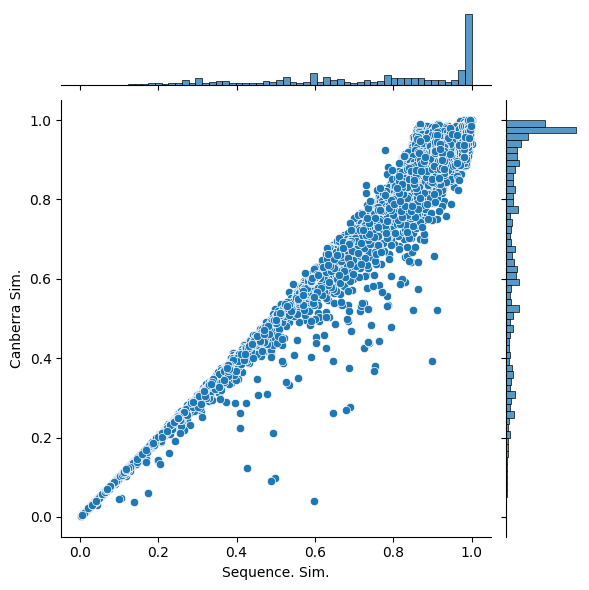

In [4]:
import numpy as np
p = sb.jointplot(data=data, x="seqsim", y="cansim")

points = p.ax_joint.collections[0]

# Get the original offsets (x, y coordinates of the points)
offsets = points.get_offsets()

# Create a mask to hide some points (e.g., hide every other point)
mask = np.arange(len(offsets)) % 5 == 0  # True for points to keep

# Apply the mask to the offsets (only keep selected points)
points.set_offsets(offsets[mask])
plt.draw()
p.set_axis_labels(ylabel="Canberra Sim.", xlabel="Sequence. Sim.")

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("Figure1_right.svg", format='svg', bbox_inches='tight')
#p.set(title="Sequence Similarity vs Canberra Similarity", )

In [5]:
from scipy.stats import pearsonr
pearsonr(data['seqsim'], data['cansim'])

PearsonRResult(statistic=0.994528686764566, pvalue=0.0)

In [6]:
len(data), ((data['seqsim'] >= 0.95) & (data['szsim'] >= 0.95)).sum()

(141680, 41152)

Of these nearby insertion pairs, 41,152 (29%) have a size and sequence similarity above 95%, which included 30,641 pairs occurring at the exact same position. From these ≥95% similar insertion pairs, 37,918 (92%) also had a Canberra similarity above 95%. Therefore, many neighboring SVs are highly similar and the Canberra similarity metric is able to differentiate them.

In [7]:
tot_pairs = len(data)
highsim_pairs = data[(data['seqsim'] >= 0.95) & (data['szsim'] >= 0.95)]
tot_pairs, len(highsim_pairs), highsim_pairs['same_start'].sum(), (highsim_pairs['cansim'] >= 0.95).sum()

(141680, 41152, 30641, 37918)

In [11]:
data.head()

,szbin,szsim,seqsim,cansim,same_start
0,"[600,800)",0.9924,0.9886,0.9912,True
1,"[1k,2.5k)",0.0690,0.1302,0.1277,False
2,"[300,400)",0.9969,0.9984,0.9984,True
3,"[1k,2.5k)",0.9979,0.9989,0.9989,True
4,"[1k,2.5k)",0.9948,0.9974,0.9974,True


In [13]:
data[(data['szsim'] >= 0.90) & (data['szbin'] == "[50,100)")]

,szbin,szsim,seqsim,cansim,same_start
45,"[50,100)",0.9180,0.9244,0.8547,False
56,"[50,100)",0.9255,0.9126,0.6893,False
66,"[50,100)",1.0000,0.8750,0.8081,False
128,"[50,100)",0.9877,0.8834,0.7712,False
221,"[50,100)",0.9756,0.8780,0.7703,False
...,...,...,...,...,...
141653,"[50,100)",1.0000,0.9107,0.8462,False
141654,"[50,100)",1.0000,0.9911,0.9630,True
141673,"[50,100)",1.0000,0.9855,0.9692,True
141674,"[50,100)",1.0000,0.9855,0.9545,True


In [14]:
rows = []
for g, d in data[data['szsim'] >= 0.90].groupby("szbin"):
    rows.append((g, len(d), *pearsonr(d['seqsim'], d['cansim'])))
view = pd.DataFrame(rows, columns=['szbin', 'N', 'corr', 'pvalue'])

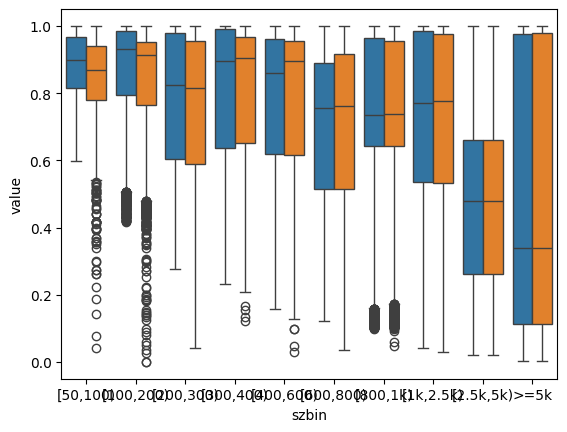

In [24]:
view2 = data.melt(id_vars=['szbin'], value_vars=['seqsim', 'cansim'])
_ = sb.boxplot(data=view2, x='szbin', y='value', hue='variable', order=truvari.SZBINS[8:])
_ = plt.legend().remove()

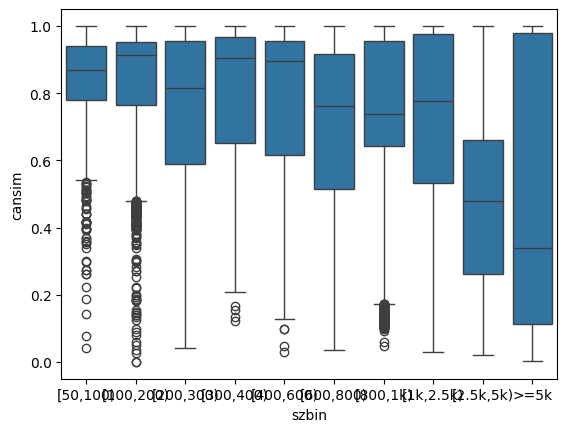

In [20]:
_ = sb.boxplot(data=data, x='szbin', y='cansim', order=truvari.SZBINS[8:])

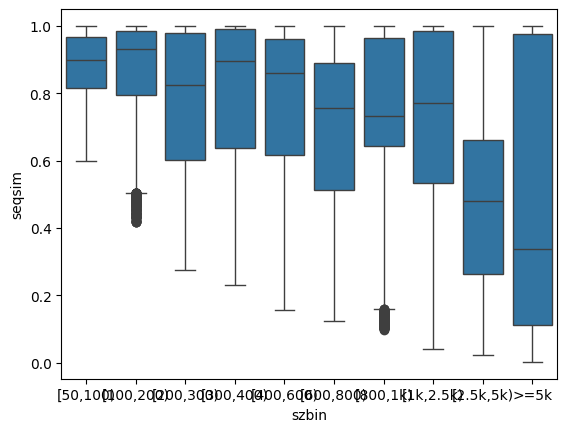

In [19]:
_ = sb.boxplot(data=data, x='szbin', y='seqsim', order=truvari.SZBINS[8:])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '[50,100)'),
  Text(1, 0, '[100,200)'),
  Text(2, 0, '[200,300)'),
  Text(3, 0, '[300,400)'),
  Text(4, 0, '[400,600)'),
  Text(5, 0, '[600,800)'),
  Text(6, 0, '[800,1k)'),
  Text(7, 0, '[1k,2.5k)'),
  Text(8, 0, '[2.5k,5k)'),
  Text(9, 0, '>=5k')])

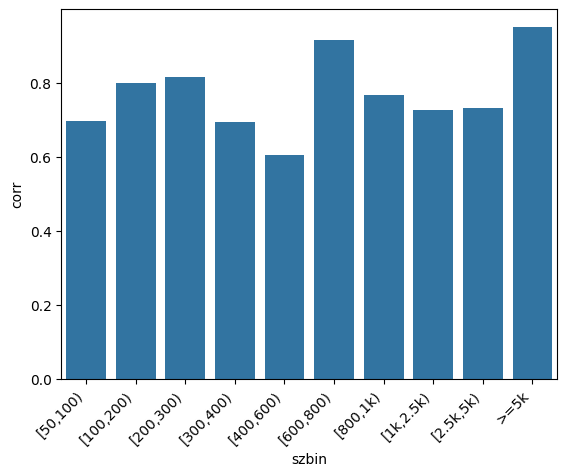

In [17]:
sb.barplot(data=view, x='szbin', y='corr', order=truvari.SZBINS[8:])
_ = plt.xticks(rotation=45, ha='right')

In [230]:
y_true = [0.1, 0.4, 0.8, 0.5]
y_pred = [0.12, 0.35, 0.78, 0.52]

# Mean Squared Error
mse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))
print(f"MSE for [0, 1] data: {mse}")



MSE for [0, 1] data: 0.03041381265149112
MSE for [0, 1] data: 3.0413812651491097


In [239]:
def report(result):
    # precision
    result["PPV"] = result["TP"] / (result['TP'] + result['FP'])
    # recall
    result["TPR"] = result["TP"] / (result['TP'] + result['FN'])
    # specificity
    result["TNR"] = result["TN"] / (result['TN'] + result['FP'])

    # negative predictive value
    result["NPV"] = result["TN"] / (result['TN'] + result['FN'])
    # accuracy
    result["ACC"] = (result["TP"] + result["TN"]) / (result['TP'] + result['TN'] + result['FP'])

    result["BA"] = (result["TPR"] + result["TNR"]) / 2

    result["F1"] = 2 * ((result["PPV"] * result["TPR"]) /
                        (result["PPV"] + result["TPR"]))

In [294]:
parts = []
oszbin = None
overall = []
for name in [3, 4, 6, 8]:
    fn = f"similarity_500.{name}.txt"
    data = pd.read_csv(fn, sep='\t').fillna(0)
    overall.append((name, RMSE(data['cansim'], data['seqsim'])))
    rows = []
    for g, d in data.groupby(['szbin']):
        seq_95 = d['seqsim'] >= 0.95
        can_95 = d['cansim'] >= 0.95
        tp = (seq_95 & can_95).sum()
        fp = (can_95 & ~seq_95).sum()
        fn = (~can_95 & seq_95).sum()
        tn = (~can_95 & ~seq_95).sum()
        rows.append((g[0], len(d), tp, fp, fn, tn, RMSE(d['cansim'], d['seqsim']) ))
    mse = pd.DataFrame(rows, columns=['szbin', 'N', 'TP', 'FP', 'FN', 'TN', f'rmse_{name}'])
    mse['szbin'] = mse['szbin'].astype(truvari.SZBINTYPE)

    mse.sort_values('szbin', inplace=True)
    report(mse)
    oszbin = mse['szbin']
    parts.append(mse[[f'rmse_{name}']])
parts.insert(0, oszbin)
summary = pd.DataFrame(overall, columns=['kmer', 'RMSE'])
mse_summary = pd.concat(parts, axis=1)[['szbin', 'rmse_3', 'rmse_4', 'rmse_6', 'rmse_8']]
mse_summary.round(4)

,szbin,rmse_3,rmse_4,rmse_6,rmse_8
7,"[50,100)",0.0596,0.0906,0.1336,0.1239
1,"[100,200)",0.0399,0.0584,0.0947,0.1219
4,"[200,300)",0.0262,0.0380,0.0712,0.0857
5,"[300,400)",0.0251,0.0324,0.0585,0.0483
6,"[400,600)",0.0350,0.0335,0.0399,0.0461
8,"[600,800)",0.0228,0.0206,0.0302,0.0405
9,"[800,1k)",0.0173,0.0171,0.0256,0.0342
2,"[1k,2.5k)",0.0148,0.0133,0.0196,0.0299
3,"[2.5k,5k)",0.0111,0.0102,0.0131,0.0140
0,>=5k,0.0098,0.0099,0.0138,0.0135


In [292]:
summary

,kmer,RMSE
0,3,0.023669
1,4,0.026815
2,6,0.040150
3,8,NaN


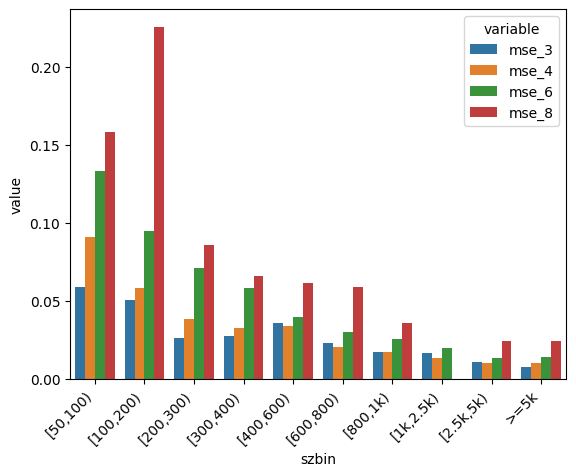

In [261]:
sb.barplot(data=mse_summary.melt(id_vars=['szbin'], value_vars=mse_summary.columns[1:]), 
           x='szbin', y='value', hue='variable',
           order=truvari.SZBINS[8:])
_ = plt.xticks(rotation=45, ha='right')

The problem with observed variants is we 
A) Don't know their 'true' similarity
B) Can presume they're more similar than not.

So, let's make some random sequences and measure them.

In [25]:
import random

def generate_dna_sequence(length, similarity, insertion_rate, deletion_rate, indel_sizemax):
    """
    Generates a random DNA sequence and mutates it to achieve a desired similarity.
    
    Args:
        length (int): Length of the original DNA sequence.
        similarity (float): Desired similarity as a percentage (e.g., 90 for 90% similarity).
        insertion_rate (float): Probability of insertions per base.
        deletion_rate (float): Probability of deletions per base.
        indel_sizemax (int): Maximum size of insertions or deletions.
    
    Returns:
        tuple: Original sequence and mutated sequence.
    """
    # Helper function to generate a random DNA base
    def random_base():
        return random.choice('ACGT')
    
    # Step 1: Generate the original DNA sequence
    original_sequence = ''.join(random_base() for _ in range(length))
    
    # Step 2: Calculate the number of substitutions needed for desired similarity
    num_substitutions = int(length * (1 - similarity / 100))
    num_insertions = int(length * insertion_rate)
    num_deletions = int(length * deletion_rate)
    
    # Step 3: Apply substitutions
    mutated_sequence = list(original_sequence)
    substitution_indices = random.sample(range(length), num_substitutions)
    for idx in substitution_indices:
        original_base = mutated_sequence[idx]
        new_base = random_base()
        while new_base == original_base:  # Ensure the substitution changes the base
            new_base = random_base()
        mutated_sequence[idx] = new_base
    
    # Step 4: Apply insertions
    for _ in range(num_insertions):
        insert_position = random.randint(0, len(mutated_sequence))
        insert_size = random.randint(1, indel_sizemax)
        insertion = ''.join(random_base() for _ in range(insert_size))
        mutated_sequence.insert(insert_position, insertion)
    
    # Step 5: Apply deletions
    for _ in range(num_deletions):
        if len(mutated_sequence) == 0:
            break  # Avoid deleting from an empty sequence
        delete_position = random.randint(0, len(mutated_sequence) - 1)
        delete_size = random.randint(1, indel_sizemax)
        del mutated_sequence[delete_position:delete_position + delete_size]
    
    # Convert mutated sequence back to string
    mutated_sequence = ''.join(mutated_sequence)
    
    return original_sequence, mutated_sequence


In [33]:
import seq_v_can_similarity as svc
def cansim(seq1, seq2, kmer=4):
    k1 = svc.kfeat(seq1, kmer)
    k2 = svc.kfeat(seq2, kmer)
    return round(svc.canberra(k1, k2), 4)

In [146]:
rows = []
for pct in [80, 85, 90, 95, 98]:
    for length in [50, 100, 200, 300, 500, 1000, 2000, 5000, 10000]:
        for i in range(100):
            a, b = generate_dna_sequence(length, pct, 0.01, 0.01, 5)
            rows.append((pct, length, truvari.seqsim(a, b), cansim(a, b, 3)))
rnd_data_3 = pd.DataFrame(rows, columns=['pct', 'length', 'seqsim', 'cansim'])

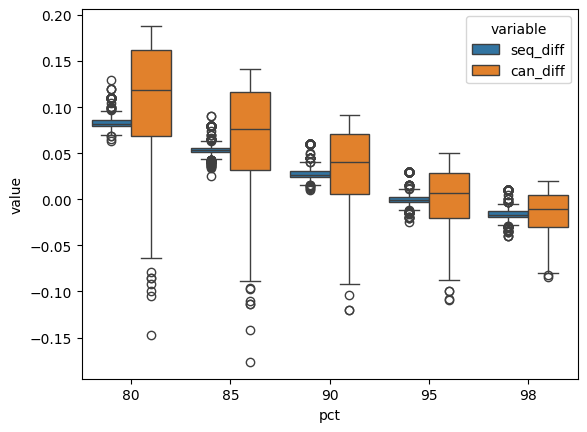

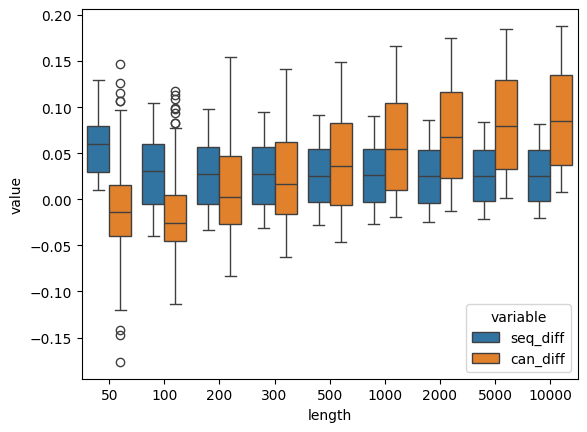

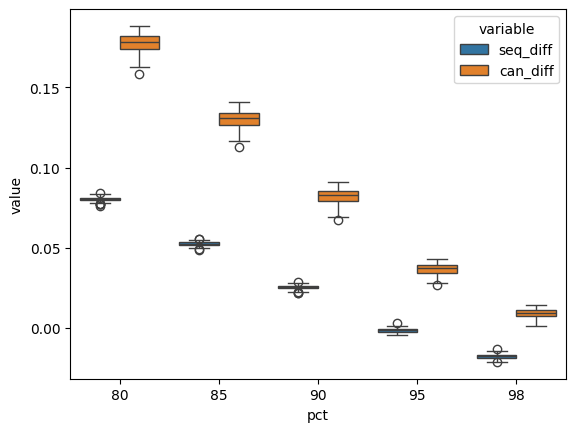

In [184]:
parts = []
#3
rnd_data_3['seq_diff'] = rnd_data_3['seqsim'] - (rnd_data_3['pct'] / 100)
rnd_data_3['can_diff'] = rnd_data_3['cansim'] - (rnd_data_3['pct'] / 100)
view2 = rnd_data_3.melt(id_vars=['pct', 'length'], value_vars=['seq_diff', 'can_diff'])
sb.boxplot(data=view2, x='pct', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2, x='length', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2[view2['length'] > 2000], x='pct', y='value', hue='variable')
plt.show()
tmp = view2.groupby(['pct', 'length', 'variable'])['value'].mean().reset_index()
tmp['k'] = 3
parts.append(tmp)

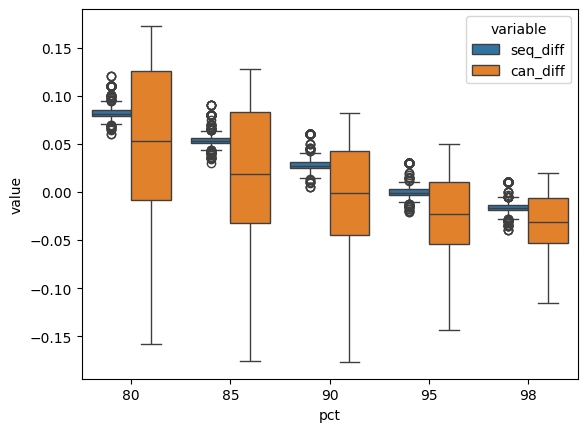

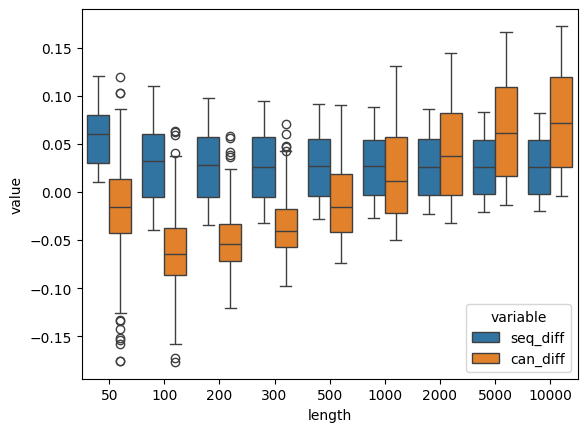

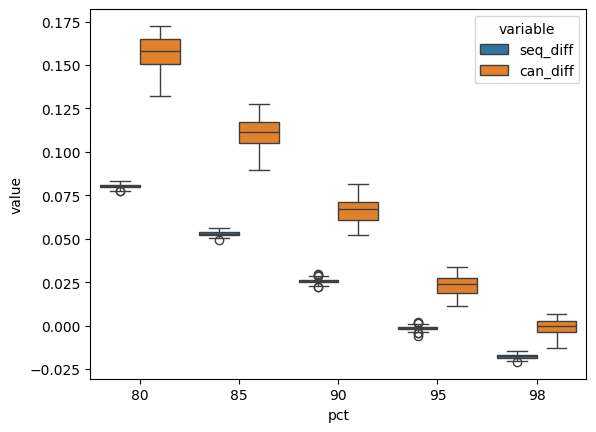

In [185]:
#4
rnd_data['seq_diff'] = rnd_data['seqsim'] - (rnd_data['pct'] / 100)
rnd_data['can_diff'] = rnd_data['cansim'] - (rnd_data['pct'] / 100)
view2 = rnd_data.melt(id_vars=['pct', 'length'], value_vars=['seq_diff', 'can_diff'])
sb.boxplot(data=view2, x='pct', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2, x='length', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2[view2['length'] > 2000], x='pct', y='value', hue='variable')
plt.show()
tmp = view2.groupby(['pct', 'length', 'variable'])['value'].mean().reset_index()
tmp['k'] = 4
parts.append(tmp)

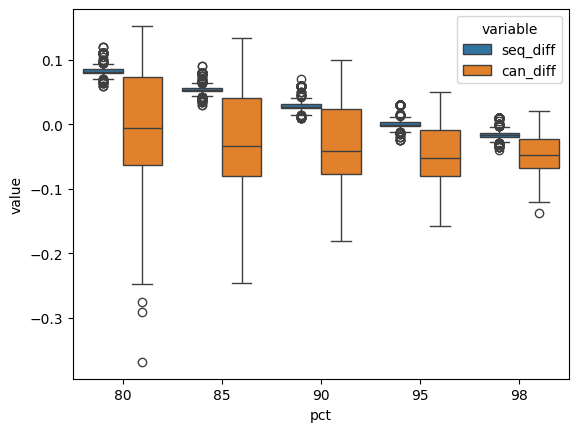

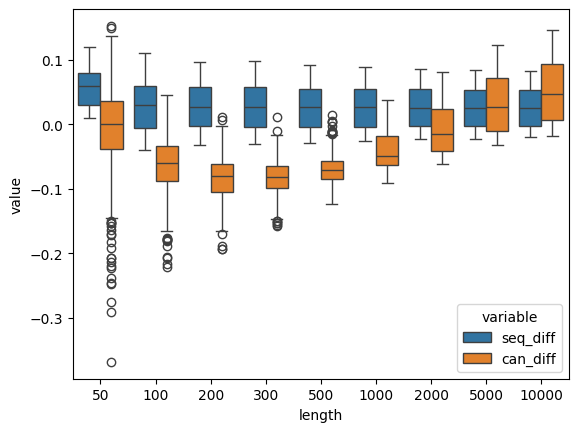

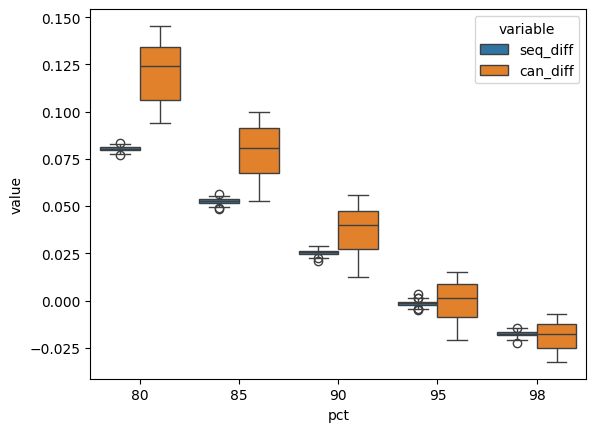

In [186]:
rnd_data_5['seq_diff'] = rnd_data_5['seqsim'] - (rnd_data_5['pct'] / 100)
rnd_data_5['can_diff'] = rnd_data_5['cansim'] - (rnd_data_5['pct'] / 100)
view2 = rnd_data_5.melt(id_vars=['pct', 'length'], value_vars=['seq_diff', 'can_diff'])
sb.boxplot(data=view2, x='pct', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2, x='length', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2[view2['length'] > 2000], x='pct', y='value', hue='variable')
plt.show()
tmp = view2.groupby(['pct', 'length', 'variable'])['value'].mean().reset_index()
tmp['k'] = 5
parts.append(tmp)

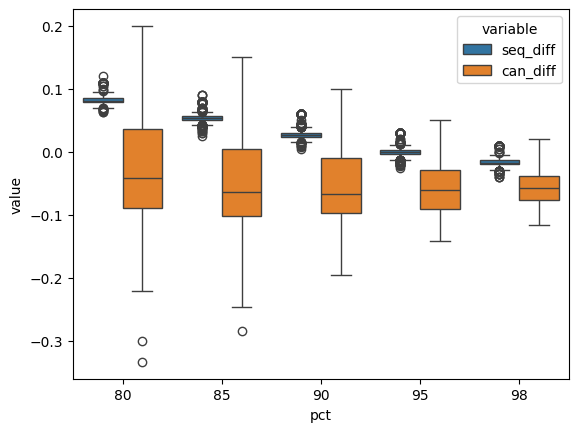

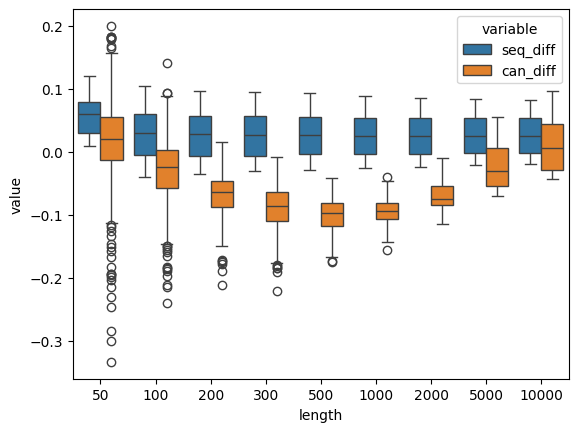

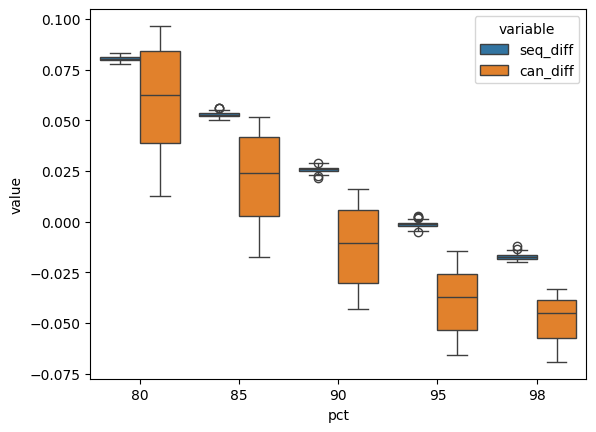

In [187]:
rnd_data_6['seq_diff'] = rnd_data_6['seqsim'] - (rnd_data_6['pct'] / 100)
rnd_data_6['can_diff'] = rnd_data_6['cansim'] - (rnd_data_6['pct'] / 100)
view2 = rnd_data_6.melt(id_vars=['pct', 'length'], value_vars=['seq_diff', 'can_diff'])
sb.boxplot(data=view2, x='pct', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2, x='length', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2[view2['length'] > 2000], x='pct', y='value', hue='variable')
plt.show()
tmp = view2.groupby(['pct', 'length', 'variable'])['value'].mean().reset_index()
tmp['k'] = 6
parts.append(tmp)

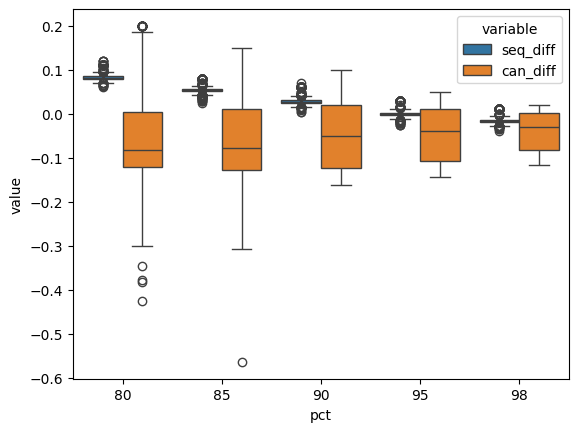

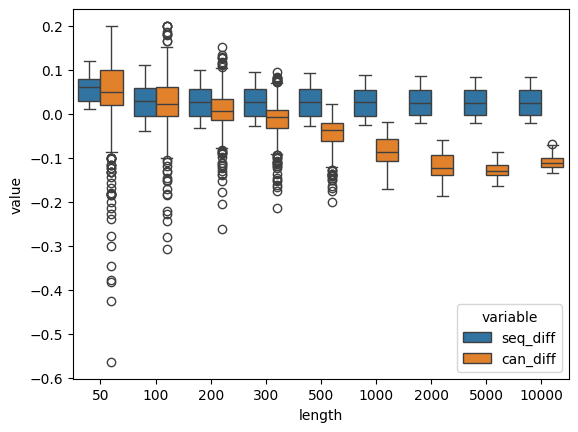

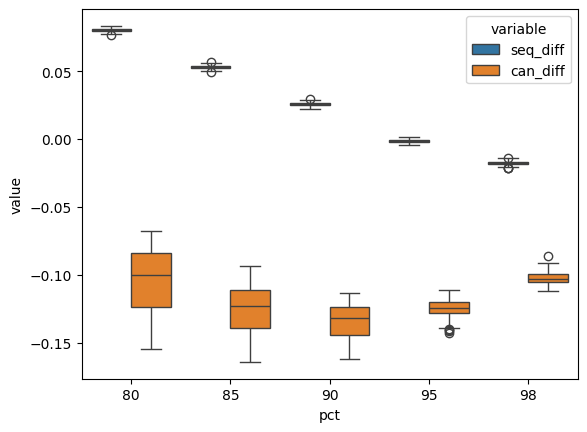

In [188]:
#8
rnd_data_8['seq_diff'] = rnd_data_8['seqsim'] - (rnd_data_8['pct'] / 100)
rnd_data_8['can_diff'] = rnd_data_8['cansim'] - (rnd_data_8['pct'] / 100)
view2 = rnd_data_8.melt(id_vars=['pct', 'length'], value_vars=['seq_diff', 'can_diff'])
sb.boxplot(data=view2, x='pct', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2, x='length', y='value', hue='variable')
plt.show()
sb.boxplot(data=view2[view2['length'] > 2000], x='pct', y='value', hue='variable')
plt.show()
tmp = view2.groupby(['pct', 'length', 'variable'])['value'].mean().reset_index()
tmp['k'] = 8
parts.append(tmp)

In [189]:
summary = pd.concat(parts)

In [191]:
summary['k'] = summary['k'].astype(str)

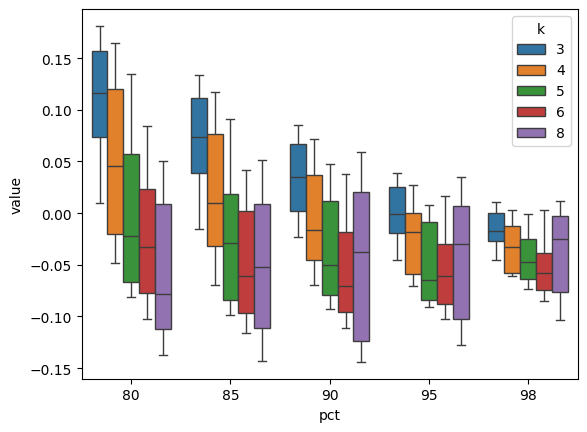

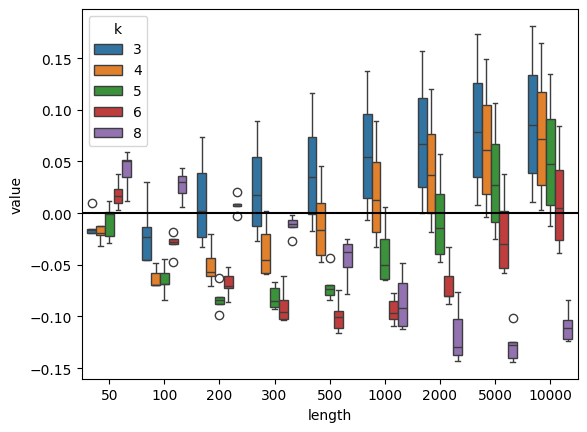

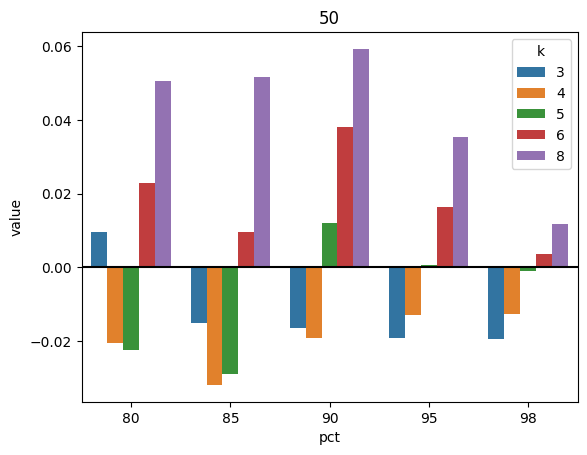

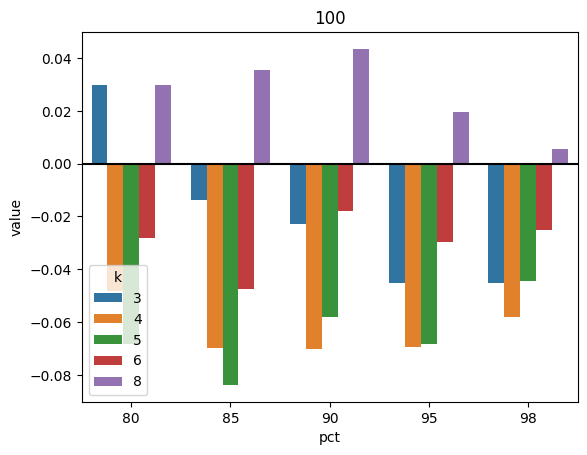

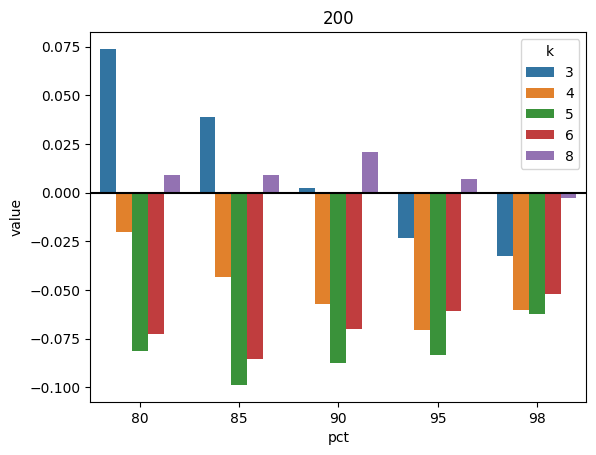

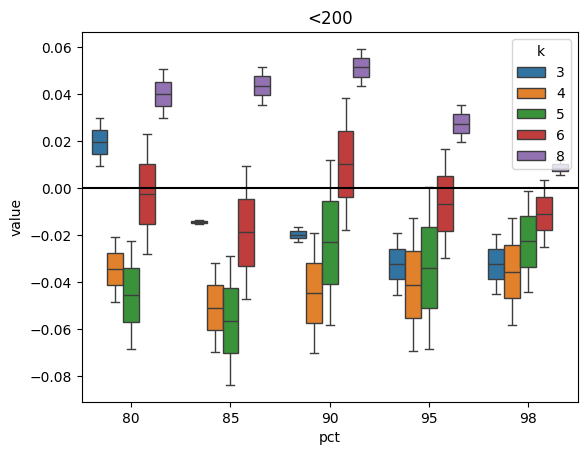

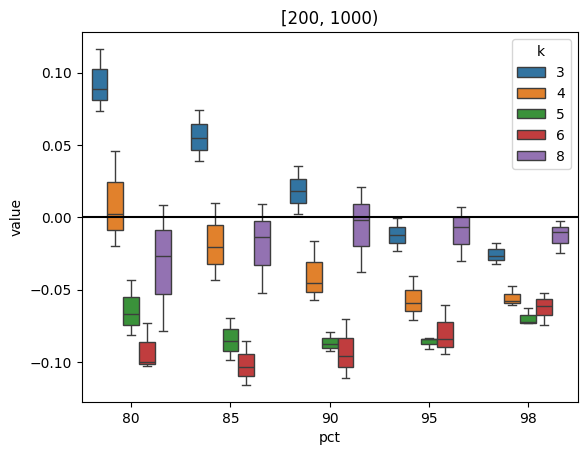

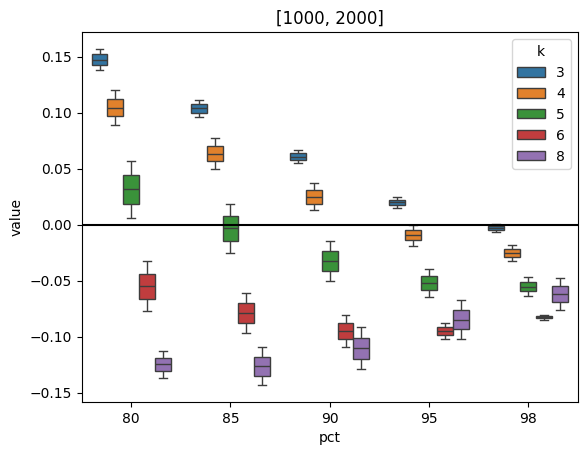

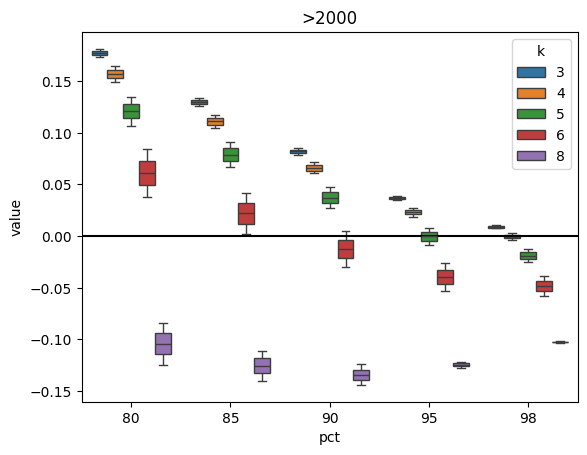

In [201]:
view = summary[summary['variable'] == 'can_diff']
sb.boxplot(data=view, x='pct', y='value', hue='k')
plt.show()
sb.boxplot(data=view, x='length', y='value', hue='k')
plt.axhline(y=0, color='black')
plt.show()

p = sb.barplot(data=view[view['length'] == 50], x='pct', y='value', hue='k')
plt.axhline(y=0, color='black')
p.set(title="50")
plt.show()

p = sb.barplot(data=view[view['length'] == 100], x='pct', y='value', hue='k')
plt.axhline(y=0, color='black')
p.set(title="100")
plt.show()

p = sb.barplot(data=view[view['length'] == 200], x='pct', y='value', hue='k')
plt.axhline(y=0, color='black')
p.set(title="200")
plt.show()

p = sb.boxplot(data=view[view['length'] < 200], x='pct', y='value', hue='k')
plt.axhline(y=0, color='black')
p.set(title="<200")
plt.show()

p = sb.boxplot(data=view[(view['length'] >= 200) & (view['length'] < 1000)], x='pct', y='value', hue='k')
plt.axhline(y=0, color='black')
p.set(title="[200, 1000)")
plt.show()

p = sb.boxplot(data=view[(view['length'] >= 1000) & (view['length'] <= 2000)], x='pct', y='value', hue='k')
plt.axhline(y=0, color='black')
p.set(title="[1000, 2000]")
plt.show()

p = sb.boxplot(data=view[view['length'] > 2000], x='pct', y='value', hue='k')
plt.axhline(y=0, color='black')
p.set(title=">2000")
plt.show()

In [133]:
rnd_data.groupby('length')[['seq_diff', 'can_diff']].describe().T

length               50          100         200         300         500    \
seq_diff count  500.000000  500.000000  500.000000  500.000000  500.000000   
         mean     0.058180    0.029879    0.029106    0.028474    0.028062   
         std      0.035663    0.038023    0.036572    0.036552    0.035549   
         min      0.010000   -0.040000   -0.034726   -0.031753   -0.028144   
         25%      0.030000   -0.005157   -0.005016   -0.004749   -0.003892   
         50%      0.060000    0.032523    0.028129    0.025681    0.026500   
         75%      0.080000    0.060000    0.057268    0.056589    0.054857   
         max      0.120000    0.110000    0.097500    0.094215    0.091109   
can_diff count  500.000000  500.000000  500.000000  500.000000  500.000000   
         mean    -0.019522   -0.063096   -0.050432   -0.036133   -0.009850   
         std      0.047646    0.037580    0.029677    0.030811    0.037532   
         min     -0.175600   -0.176600   -0.120100   -0.098100   -0.073800   
         25%     -0.043150   -0.086650   -0.071400   -0.057700   -0.042025   
         50%     -0.016050   -0.064200   -0.054400   -0.040900   -0.015750   
         75%      0.013750   -0.037075   -0.032875   -0.017650    0.018225   
         max      0.119500    0.063400    0.058600    0.070600    0.090700   

length               1000        2000        5000        10000  
seq_diff count  500.000000  500.000000  500.000000  500.000000  
         mean     0.028178    0.028168    0.027996    0.027991  
         std      0.035951    0.035722    0.035592    0.035577  
         min     -0.026813   -0.023054   -0.020863   -0.020108  
         25%     -0.003478   -0.002915   -0.002048   -0.002147  
         50%      0.026720    0.025875    0.025672    0.025516  
         75%      0.054277    0.054571    0.053697    0.053490  
         max      0.088052    0.085686    0.083153    0.082335  
can_diff count  500.000000  500.000000  500.000000  500.000000  
         mean     0.020031    0.043185    0.065995    0.076733  
         std      0.045981    0.050917    0.056114    0.058919  
         min     -0.050300   -0.032100   -0.013100   -0.003800  
         25%     -0.022000   -0.003225    0.016875    0.025775  
         50%      0.011700    0.037000    0.060900    0.071150  
         75%      0.056675    0.082175    0.108725    0.119950  
         max      0.130900    0.143900    0.166200    0.172500

[Text(0, 0.5, 'Similarity')]

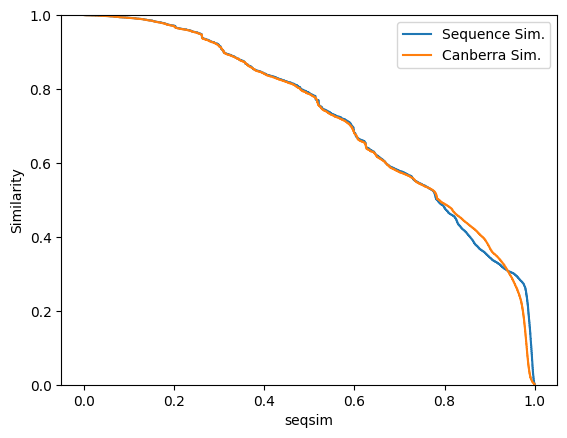

In [49]:
sb.ecdfplot(data=data, x="seqsim", label="Sequence Sim.", complementary=True)
p = sb.ecdfplot(data=data, x="cansim", label="Canberra Sim.", complementary=True)
plt.legend()
p.set(ylabel="Similarity")